In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import rotate, gaussian_filter
from PIL import Image
from ipywidgets import interact, IntSlider, FloatLogSlider
from numpy.fft import fft2, ifft2, fftshift
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
class ARPESImageLoader:
    def __init__(self, condition, basepath, basename, basename2, ext, n_files):
        # Convert condition from string to float where 'p' indicates the decimal point
        self.energy = float(condition.replace('p', '.'))
        # Construct the file path for the given condition
        condition_str = condition
        image_path = f"{basepath}{basename}{condition_str}{basename2}{str(n_files).zfill(3)}{ext}"
        #image_path = 
        # Load and store the image
        self.image = np.array(Image.open(image_path))
        self.nobackground = []

In [3]:
# Example usage:
basepath = '.\\ARPES_Deconvolution'
basename = '\\ARPES_Ag_Ekin'
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
basename2 = '_He5p5m2_100mA_AV_'
ext = '.TIF'
n_files = 1

# Create a list of ARPESImageLoader objects, one for each condition
arpes_loaders_5p5_100mA = [ARPESImageLoader(energy, basepath, basename, basename2, ext, n_files) for energy in energies]

In [4]:
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
basename2 = '_He8p3m2_35mA_AV_'
arpes_loaders_8p3_35mA = [ARPESImageLoader(energy, basepath, basename, basename2, ext, n_files) for energy in energies]

In [5]:
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
basename3 = '_He6p5m2_100mA_AV_'
arpes_loaders_6p5_100mA = [ARPESImageLoader(energy, basepath, basename, basename3, ext, n_files) for energy in energies]


In [6]:
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
basename4 = '_He6p0m2_120mA_AV_'
arpes_loaders_6p0_120mA = [ARPESImageLoader(energy, basepath, basename, basename4, ext, n_files) for energy in energies]

In [17]:
en = np.asarray([ar.energy for ar in arpes_loaders_5p5_100mA])
conditions = [arpes_loaders_5p5_100mA,arpes_loaders_6p5_100mA,arpes_loaders_6p0_120mA,arpes_loaders_8p3_35mA,]
energy = 23.52
index = np.where(energy==en)[0][0]
pixels = np.zeros((1024,1024,len(en),len(conditions)),dtype = int)
for k,energy in enumerate(en):
    for l,con in enumerate(conditions):
                pixels[:,:,k,l] = con[k].image

In [8]:
# Prepare to store cluster labels
num_energies = len(en)
num_conditions = len(conditions)
labels = np.zeros((1024, 1024,num_energies), dtype=int)
num_pixels = 1024 * 1024
num_clusters =  6
for k in range(len(en)):
    print(f"Processing energy level {k + 1}/{num_energies}")
    
    # Extract data at energy level k
    data_at_energy = pixels[:, :, k, :]  # Shape: (1024, 1024, 5)
    
    # Reshape data to (num_pixels, num_conditions)
    data_reshaped = data_at_energy.reshape(num_pixels, num_conditions)
    
    # Standardize the features
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_reshaped)


    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data_standardized)
    
    # Get cluster labels
    labels_at_energy = kmeans.labels_
    labels[:, :, k] = labels_at_energy.reshape(1024, 1024)

Processing energy level 1/13
Processing energy level 2/13
Processing energy level 3/13
Processing energy level 4/13
Processing energy level 5/13
Processing energy level 6/13
Processing energy level 7/13
Processing energy level 8/13
Processing energy level 9/13
Processing energy level 10/13
Processing energy level 11/13
Processing energy level 12/13
Processing energy level 13/13


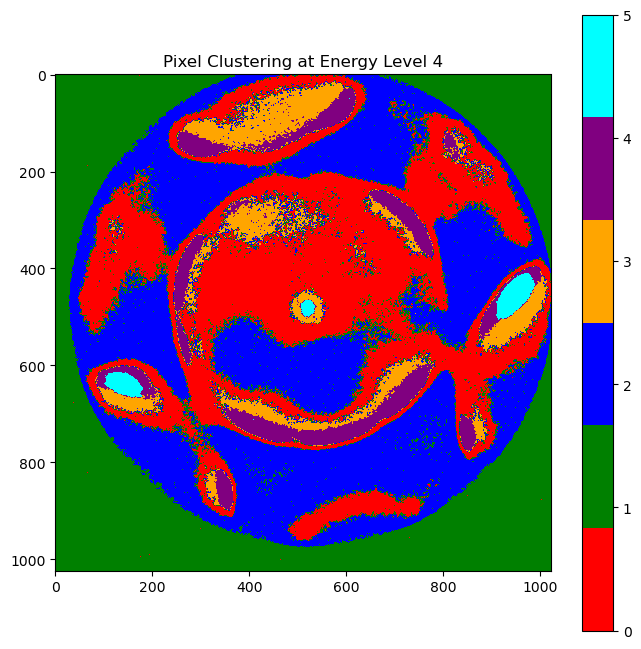

In [12]:
from matplotlib.colors import ListedColormap

energy_level =3
# Generate a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# If num_clusters exceeds the number of predefined colors, repeat the colors
if num_clusters > len(colors):
    colors = colors * (num_clusters // len(colors) + 1)

# Create a colormap with the number of clusters
cmap = ListedColormap(colors[:num_clusters])

# Plotting remains the same
plt.figure(figsize=(8, 8))
plt.imshow(labels[:, :, energy_level], cmap=cmap, vmin=0, vmax=num_clusters - 1)
plt.colorbar(ticks=range(num_clusters))
plt.title(f'Pixel Clustering at Energy Level {energy_level + 1}')
plt.show()

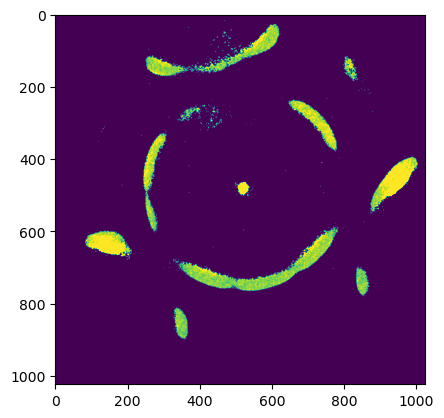

In [20]:
for i in range(1024):
    for j in range(1024):
        if labels[i,j,energy_level]==1 or labels[i,j,energy_level]==0 or labels[i,j,energy_level]==2 or labels[i,j,energy_level]==3:
            pixels[i,j,energy_level,0]=0

plt.imshow(pixels[:, :, energy_level,0],vmin=0,vmax=80)

In [21]:
data_reshaped = pixels.reshape(num_pixels, num_energies, num_conditions)
num_clusters = 6  # Adjust as needed
# Compute statistical features across energies
mean_intensity = data_reshaped.mean(axis=1)       # Shape: (num_pixels, 5)
std_intensity = data_reshaped.std(axis=1)         # Shape: (num_pixels, 5)
median_intensity = np.median(data_reshaped, axis=1)  # Shape: (num_pixels, 5)

# Prepare to store cluster labels
labels = np.zeros((1024, 1024, num_energies), dtype=int)

for k in range(num_energies):
    print(f"Processing energy level {k + 1}/{num_energies}")
    
    neighboring_energies = []
    if k > 0:
        neighboring_energies.append(k - 1)
    if k < num_energies - 1:
        neighboring_energies.append(k + 1)
    
    # Feature components
    features_list = []
    
    # Intensities at energy k
    features_list.append(data_reshaped[:, k, :])  # (num_pixels, 5)
    
    # Intensities at neighboring energies
    for n in neighboring_energies:
        features_list.append(data_reshaped[:, n, :])  # (num_pixels, 5)
    
    # Statistical features
    features_list.append(mean_intensity)
    features_list.append(std_intensity)
    features_list.append(median_intensity)
    
    # Intensity differences between conditions at energy k
    intensity_k = data_reshaped[:, k, :]  # (num_pixels, 5)
    differences = []
    for i in range(num_conditions):
        for j in range(i + 1, num_conditions):
            diff = intensity_k[:, i] - intensity_k[:, j]
            differences.append(diff.reshape(-1, 1))
    differences = np.hstack(differences)  # Shape: (num_pixels, 10)
    features_list.append(differences)
    
    # Combine all features
    features = np.hstack(features_list)
    
    # Standardize features
    scaler = StandardScaler()
    features_standardized = scaler.fit_transform(features)
    
    # Clustering

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features_standardized)
    
    # Assign labels
    labels_flat = kmeans.labels_
    labels[:, :, k] = labels_flat.reshape(1024, 1024)


Processing energy level 1/13
Processing energy level 2/13
Processing energy level 3/13
Processing energy level 4/13
Processing energy level 5/13
Processing energy level 6/13
Processing energy level 7/13
Processing energy level 8/13
Processing energy level 9/13
Processing energy level 10/13
Processing energy level 11/13
Processing energy level 12/13
Processing energy level 13/13


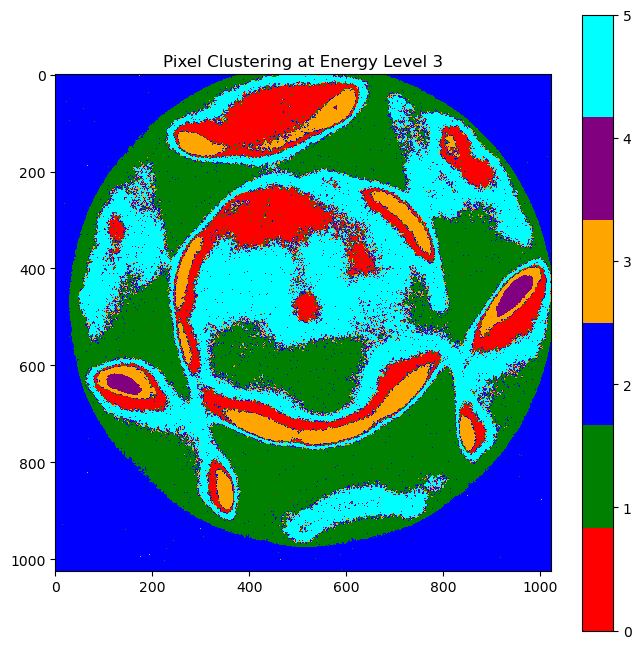

In [22]:
energy_level = 2
# Generate a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# If num_clusters exceeds the number of predefined colors, repeat the colors
if num_clusters > len(colors):
    colors = colors * (num_clusters // len(colors) + 1)

# Create a colormap with the number of clusters
cmap = ListedColormap(colors[:num_clusters])

# Plotting remains the same
plt.figure(figsize=(8, 8))
plt.imshow(labels[:, :, energy_level], cmap=cmap, vmin=0, vmax=num_clusters - 1)
plt.colorbar(ticks=range(num_clusters))
plt.title(f'Pixel Clustering at Energy Level {energy_level + 1}')
plt.show()

In [15]:
plt.figure(figsize=(, 8))
plt.imshow(pixels[:, :, energy_level,0],vmin=0,vmax=100)

SyntaxError: invalid syntax (1292112404.py, line 1)